In [1]:
from numpy import *
from scipy import signal
from scipy.integrate import quad
import TMQGP as tm
import tqdm.notebook as tqdm
from QuarkTM import Particle, Channel
import QuarkTM
import pickle
import matplotlib

In [2]:
((47.5/16)**(1/3) ) * 0.155

0.22276976180911218

In [3]:
sqrt(940**2 + 300**2)

986.7117106835208

In [4]:
(47.5/16)**0.25 

1.3126332671432939

In [5]:
from syntax_sugar import pipe, END
from syntax_sugar import thread_syntax as t, process_syntax as p

NTHR = 14

# Import data

In [6]:
mode = 'LO'

In [7]:
folder = 'output/TestL1'+mode+'_G=6.00L=0.500MG=1.60screen=0.060/'

In [8]:
trange = array([0.2, 0.3, 0.4, 0.5])

In [9]:
lmax = 1

In [10]:
pQs = []
pGs = []

ch_names_Q = ['qa1', 'qa8', 'qq3', 'qq6', 'qg3', 'qg6', 'qg15']
ch_names_G = ['gq3', 'gq6', 'gq15', 'gg1', 'gg16', 'gg27']

TMs_Q = []
TMs_G = []
Xs_Q = []
Xs_G = []
# Sigmas = []
SQs = []
SGs = []


for T in trange:
    qrange = np.loadtxt(folder + 'qrange_T=%.3f.dat'%T)
    erange = np.loadtxt(folder + 'erange_T=%.3f.dat'%T)
    Gtab_Q = np.loadtxt(folder + 'Q_G_T=%.3f.dat'%T, dtype=complex)
    
    Gtab_Q = 1/(1/Gtab_Q - 0*5e-2j)
    
    pQ = QuarkTM.Particle(0.5, qrange, erange, 
                         Gtab=Gtab_Q)
    pQs += [pQ]

    Gtab_G = np.loadtxt(folder + 'G_G_T=%.3f.dat'%T, dtype=complex)
    
    Gtab_G = 1/(1/Gtab_G - 0*5e-2j)
    
    pG = QuarkTM.Particle(1.4, qrange, erange, 
                         Gtab=Gtab_G, stat='b', d=16)
    pGs += [pG]
    
    
    SQ = np.loadtxt(folder + 'Q_S_T=%.3f.dat'%T, dtype=complex)
    
    SQs += [SQ]

    SG = np.loadtxt(folder + 'G_S_T=%.3f.dat'%T, dtype=complex)
    
    SGs += [SG]

    tmss_Q = []
    smss_Q = []
    xmss_Q = []

    for l in range(lmax + 1):
        tms_Q = dict()
        sms_Q = dict()
        xms_Q = dict()
        for ch in ch_names_Q:
    #         print(ch)
            _tm = np.loadtxt(folder + f'Q_TM_{ch}_l=%i_T=%.3f.dat'%(l,T),
                           dtype=complex)
            
            _x = np.loadtxt(folder + f'Q_X_{ch}_l=%i_T=%.3f.dat'%(l,T),
                           dtype=complex)
            tms_Q[ch] = _tm
            
    #         sigma = np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T)
            # sigma = (1j*np.loadtxt(folder + f'Q_ImS_{ch}_T=%.3f.dat'%T)
            #         + np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T))
            
            # sms[ch] = sigma
            xms_Q[ch] = _x
        tmss_Q += [tms_Q]
        xmss_Q += [xms_Q]

    tmss_G = []
    smss_G = []
    xmss_G = []

    tms_G = dict()
    sms_G = dict()
    xms_G = dict()

    for l in range(lmax + 1):
        for ch in ch_names_G:
    #         print(ch)
            _tm = np.loadtxt(folder + f'G_TM_{ch}_l=%i_T=%.3f.dat'%(l,T),
                           dtype=complex)
            
            _x = np.loadtxt(folder + f'G_X_{ch}_l=%i_T=%.3f.dat'%(l,T),
                           dtype=complex)
            tms_G[ch] = _tm
            
    #         sigma = np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T)
            # sigma = (1j*np.loadtxt(folder + f'Q_ImS_{ch}_T=%.3f.dat'%T)
            #         + np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T))
            
            # sms[ch] = sigma
            xms_G[ch] = _x

        tmss_G += [tms_G]
        xmss_G += [xms_G]
    
        
    Xs_Q += [xmss_Q]
    TMs_Q += [tmss_Q]
    Xs_G += [xmss_G]
    TMs_G += [tmss_G]
    # Sigmas += [sms]

# Quasiparticle pressure

In [11]:
ps_Q = array([tm.OmQ_F(T, pt.iImG, pt.iReG) 
            for T, pt in zip(trange, pQs)])

In [12]:
ps_G = array([tm.OmQ_B(T, pt.iImG, pt.iReG) 
            for T, pt in zip(trange, pGs)])

In [13]:
from scipy.integrate import quad

Pfree_Q = array([quad(lambda z: z*z*T*log(1 + exp(-sqrt(0.5**2 + z**2)/T)) / 2/pi**2, 0, 5)[0] for T in trange])
Pfree_G = array([quad(lambda z: -z*z*T*log(1 - exp(-sqrt(1.6**2 + z**2)/T)) / 2/pi**2, 0, 5)[0] for T in trange])

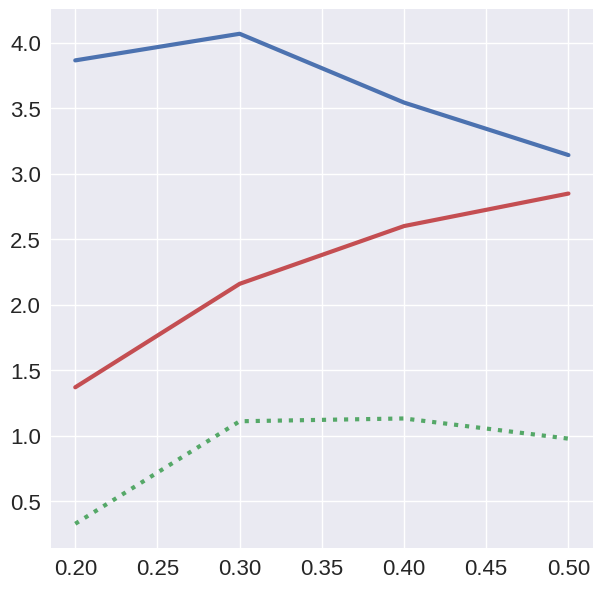

In [14]:
plt.plot(trange, 3*3*2*2*ps_Q/trange**4)
plt.plot(trange, 8*2*ps_G/trange**4, ls=':')

plt.plot(trange, 3*3*2*2*Pfree_Q/trange**4)

# Self-energy pressure 

In [15]:
ps_S_Q = []
ps_S_G = []

# ps_S2 = []

for T, pt, sig_tot in zip(trange, pQs, SQs):
#     sigma = np.sum(list(sms.values()), axis=0) - 1e-3j
    sigma = sig_tot
#     plt.plot(erange, real(sigma[:, 0]))
    iReS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(sigma)))
    iImS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(sigma)))
    
    iImG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(pt.Gtab)))
    iReG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(pt.Gtab)))
    
#     break
#     print(T)
    ps_S_Q += [tm.OmS_F(T, iImG, iReG, iImS, iReS)]

for T, pt, sig_tot in zip(trange, pGs, SGs):
#     sigma = np.sum(list(sms.values()), axis=0) - 1e-3j
    sigma = sig_tot
#     plt.plot(erange, real(sigma[:, 0]))
    iReS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(sigma)))
    iImS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(sigma)))
    
    iImG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(pt.Gtab)))
    iReG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(pt.Gtab)))
    
#     break
#     print(T)
    ps_S_G += [tm.OmS_B(T, iImG, iReG, iImS, iReS)]
#     ps_S2 += [tm.OmS2_F(T, iImG, iReG, iImS, iReS)]
ps_S_Q = array(ps_S_Q)
ps_S_G = array(ps_S_G)

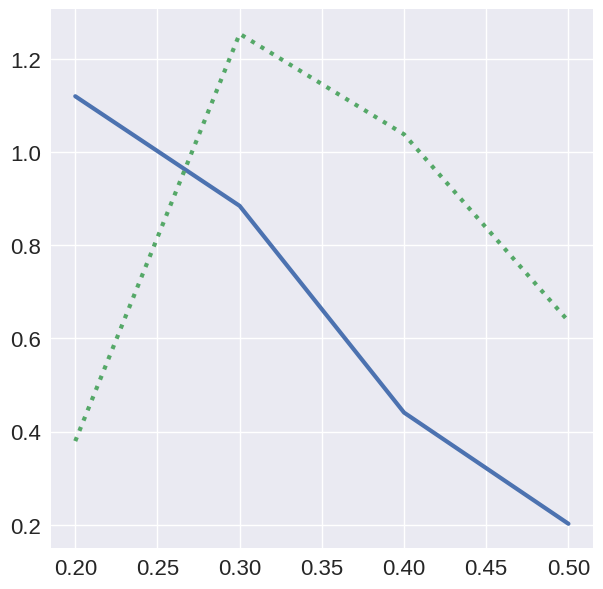

In [16]:
plt.plot(trange, 3*3*2*ps_S_Q/trange**4)
plt.plot(trange, 8*2*ps_S_G/trange**4, ls=':')

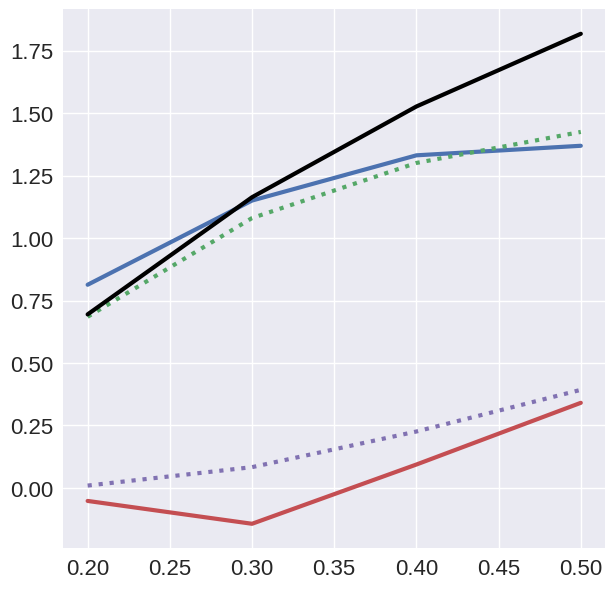

In [17]:
plt.plot(trange, 3*3*2*(ps_Q - ps_S_Q)/trange**4)
plt.plot(trange, 3*3*2*Pfree_Q/trange**4, ls=':')
plt.plot(trange, 8*2*(ps_G - ps_S_G)/trange**4)
plt.plot(trange, 8*2*Pfree_G/trange**4, ls=':')
plt.plot(trange, 8*2*Pfree_G/trange**4 + 3*3*2*Pfree_Q/trange**4, c='black')

# $\Phi$ pressure

In [18]:
NFS = {
    'qa1' : 3, 'qa8' : 3, 'qq3' : 3, 'qq6' : 3, 'qg3' : 1, 'qg6' : 1, 'qg15' : 1,
    'gq3' : 3, 'gq6' : 3, 'gq15' : 3, 'gg1' : 1, 'gg16' : 1, 'gg27' : 1
}

## Quarks

In [19]:
keys_QQ = ['qa1', 'qa8', 'qq3', 'qq6']

keys_QG = ['qg3', 'qg6', 'qg15']

In [22]:
Phis_Q = []

LTs_QQ = dict()
LTs_QG = dict()
Vs = dict()

LSs_QQ = []
LSs_QG = []

for i, T in enumerate(trange[:]):
    xms = Xs_Q[i]
    tms = TMs_Q[i]

    LT_QQ = 0
    LT_QG = 0
    
    # for k in keys_QQ:
    #     ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
    #     lt = 0
    #     lts = []
    #     for l in range(lmax + 1):
    #         xms = xmss_Q[l]
    #         x = xms[k]
    #         v = np.loadtxt(folder + f'{k}_vq_l=%i_T=%.3f.dat'%(l, T))
    #         Vs[k] = v
    #         # print(k, ds, da, Fa, NFS[k])
    #         _lt = (2*l + 1) * sign(v[1])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
    #         LT_QQ += _lt
    #         lts += [_lt]
    #     LTs_QQ[k] = [lts]

    # for k in keys_QG:
    #     ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
    #     lt = 0
    #     lts = []
    #     for l in range(lmax + 1):
    #         xms = xmss_Q[l]
    #         x = xms[k]
    #         v = np.loadtxt(folder + f'{k}_vq_l=%i_T=%.3f.dat'%(l, T))
    #         Vs[k] = v
    #         # print(k, ds, da, Fa, NFS[k])
    #         _lt = (2*l + 1) * sign(v[1])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
    #         LT_QG += _lt
    #         lts += [_lt]
    #     LTs_QG[k] = [lts]
            
    
    for k, x in xmss_Q[0].items():
        # x = xms[k]
        # if k == 'qq3':
        # print(NFS[k])
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        v = np.loadtxt(folder + f'{k}_vq_T=%.3f.dat'%T)
        Vs[k] = v
        print(k, ds, da, Fa, NFS[k])
        lt = sign(v[0])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
        if k in keys_QQ:
            LT_QQ += lt
            LTs_QQ[k] = lt
        elif k in keys_QG:
            LT_QG += lt
            LTs_QG[k] = lt
        else:
            pass

    # break
    ImSTs = []
    ReSTs = []
    for LT, func, p2 in zip([LT_QQ, LT_QG], [tm.sigma_ff_onshell, tm.sigma_fb_onshell], [pQs[i], pGs[i]]):
        iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(LT)))
        #pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END

        iEps1 = tm.Interpolator(qrange, pQs[i].om0(qrange), 'linear')
        iEps2 = tm.Interpolator(qrange, p2.om0(qrange), 'linear')
        
        ST = array([
            pipe(erange) | p[lambda z: func(z, q, trange[i], iImLT, p2.R, 
                                           iEps1, iEps2)] * NTHR | END
                    for q in tqdm.tqdm(qrange)])
    
        ST = ST.transpose()
    
        ReST = []
    
        for res in (ST.transpose()):
            iImSigma = tm.Interpolator(erange, np.ascontiguousarray(res), 'cubic')
            ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange]
            ReST += [ReSigma]

        ReST = np.array(ReST).transpose()

        ImSTs += [ST]
        ReSTs += [ReST]

    iImST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ImSTs, axis=0)))
    iReST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ReSTs, axis=0)))

    LSs_QQ += [1j*ST + ReST]
    
    pt = pQs[i]

    Phi = 0.5 * tm.OmS_B(trange[i], pt.iImG, pt.iReG, iImST, iReST)
    Phis_Q += [Phi]

qa1 4.0 1.0 1.0 3
qa8 4.0 8.0 0.125 3
qq3 4.0 3.0 0.5 3
qq6 4.0 6.0 0.25 3
qg3 4.0 3.0 1.125 1
qg6 4.0 6.0 0.375 1
qg15 4.0 15.0 0.375 1


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

qa1 4.0 1.0 1.0 3
qa8 4.0 8.0 0.125 3
qq3 4.0 3.0 0.5 3
qq6 4.0 6.0 0.25 3
qg3 4.0 3.0 1.125 1
qg6 4.0 6.0 0.375 1
qg15 4.0 15.0 0.375 1


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

qa1 4.0 1.0 1.0 3
qa8 4.0 8.0 0.125 3
qq3 4.0 3.0 0.5 3
qq6 4.0 6.0 0.25 3
qg3 4.0 3.0 1.125 1
qg6 4.0 6.0 0.375 1
qg15 4.0 15.0 0.375 1


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

qa1 4.0 1.0 1.0 3
qa8 4.0 8.0 0.125 3
qq3 4.0 3.0 0.5 3
qq6 4.0 6.0 0.25 3
qg3 4.0 3.0 1.125 1
qg6 4.0 6.0 0.375 1
qg15 4.0 15.0 0.375 1


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [121]:
LTs_QG['qg3']

[[array([[-5.23446107e+02-7.19404865e-07j, -3.32618450e+02-4.57138429e-07j,
          -1.19818879e+02-1.64674612e-07j, ...,
          -5.54688409e-03-7.62343123e-12j, -4.04999423e-03-5.56616147e-12j,
          -3.00252043e-03-4.12655242e-12j],
         [-5.31704983e+02-1.21886823e-06j, -3.37866468e+02-7.74517290e-07j,
          -1.21709369e+02-2.79003746e-07j, ...,
          -5.63440223e-03-1.29161736e-11j, -4.11389460e-03-9.43059699e-12j,
          -3.04989387e-03-6.99150628e-12j],
         [-5.31817204e+02-2.11411356e-06j, -3.37937778e+02-1.34339174e-06j,
          -1.21735056e+02-4.83928936e-07j, ...,
          -5.63559142e-03-2.24029613e-11j, -4.11476288e-03-1.63572670e-11j,
          -3.05053758e-03-1.21266909e-11j],
         ...,
         [-4.81325333e+02-1.92852850e+01j, -3.05853237e+02-1.22546362e+01j,
          -1.10177268e+02-4.41447783e+00j, ...,
          -5.10053622e-03-2.04363427e-04j, -3.72409842e-03-1.49213628e-04j,
          -2.76091297e-03-1.10621631e-04j],
         [

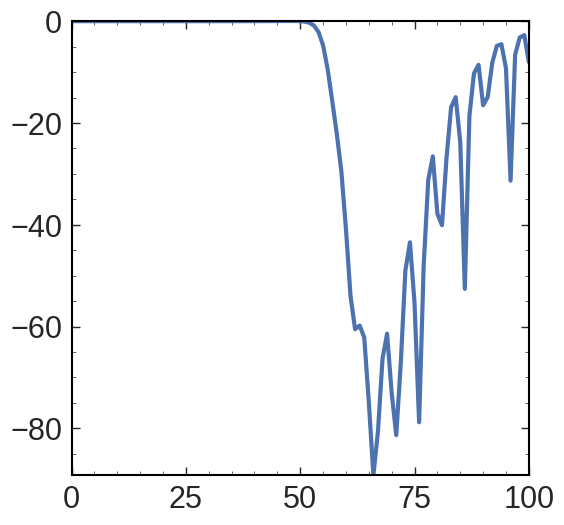

In [107]:
plt.plot(imag(LT_QQ[:, 0]))

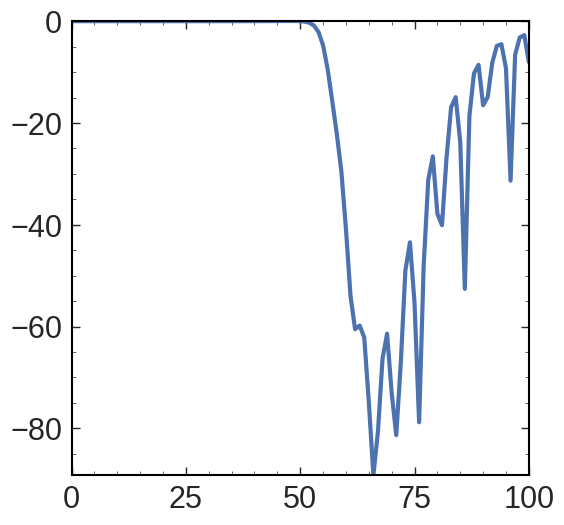

In [108]:
plt.plot(imag(LT_QQ[:, 0]))

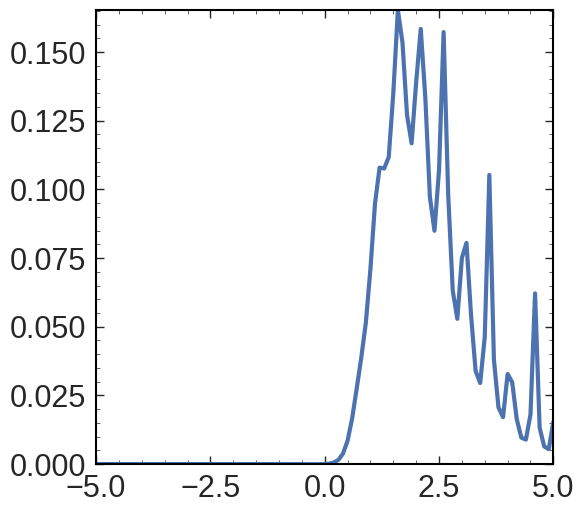

In [102]:
plt.plot(erange, imag(xmss_Q[0]['qa1'][:, 0]))

In [38]:
keys_GG = ['gg1', 'gg16', 'gg27']
keys_GQ = ['gq3', 'gq6', 'gq15']

In [130]:
Phis_G = []

LTs_GG = dict()
LTs_GQ = dict()
Vs = dict()

LSs_GG = []
LSs_GQ = []

for i, T in enumerate(trange[:]):
    xms = Xs_G[i]
    tms = TMs_G[i]

    LT_GG = 0
    LT_GQ = 0
    

    for k in keys_GG:
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        lt = 0
        lts = []
        for l in range(lmax + 1):
            xms = xmss_G[l]
            x = xms[k]
            v = np.loadtxt(folder + f'{k}_vq_l=%i_T=%.3f.dat'%(l, T))
            Vs[k] = v
            # print(k, ds, da, Fa, NFS[k])
            _lt = (2*l + 1) * sign(v[1])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
            LT_GG += _lt
            lts += [_lt]
        LTs_GG[k] = [lts]

    for k in keys_GQ:
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        lt = 0
        lts = []
        for l in range(lmax + 1):
            xms = xmss_G[l]
            x = xms[k]
            v = np.loadtxt(folder + f'{k}_vq_l=%i_T=%.3f.dat'%(l, T))
            Vs[k] = v
            # print(k, ds, da, Fa, NFS[k])
            _lt = (2*l + 1) * sign(v[1])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
            LT_GQ += _lt
            lts += [_lt]
        LTs_GQ[k] = [lts]
    
    # for k, x in xms.items():
    #     # x = xms[k]
    #     # if k == 'qq3':
    #     # print(NFS[k])
    #     ds, da, Fa = np.loadtxt(folder + f'{k}_weights')

    #     #### adding the p-wave

    #     lt = 0

    #     for l in range(lmax + 1):
    #         v = np.loadtxt(folder + f'{k}_vq_l=%i_T=%.3f.dat'%(l, T))
    #         Vs[k] = v
    #         print(k, ds, da, Fa)
    #         lt += sign(v[0])*4*pi*NFS[k]*ds * da / 6 * v**2 / x * log(1 - x)
            
    #     if k in keys_GG:
    #         LT_GG += lt
    #         LTs_GG[k] = lt 
    #     elif k in keys_GQ:
    #         LT_GQ += lt
    #         LTs_GQ[k] = lt 
    #     else:
    #         pass

    # break
    ImSTs = []
    ReSTs = []
    for LT, func, p2 in zip([LT_GG, LT_GQ], [tm.sigma_bb_onshell, tm.sigma_bf_onshell], [pGs[i], pQs[i]]):
        iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(LT)))
        #pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END

        iEps1 = tm.Interpolator(qrange, pGs[i].om0(qrange), 'linear')
        iEps2 = tm.Interpolator(qrange, p2.om0(qrange), 'linear')
        
        ST = array([
            pipe(erange) | p[lambda z: func(z, q, trange[i], iImLT, p2.R, iEps1, iEps2)] * NTHR | END
                    for q in tqdm.tqdm(qrange)])
    
        ST = ST.transpose()
    
        ReST = []
    
        for res in (ST.transpose()):
            iImSigma = tm.Interpolator(erange, np.ascontiguousarray(res), 'cubic')
            ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange]
            ReST += [ReSigma]

        ReST = np.array(ReST).transpose()

        ImSTs += [ST]
        ReSTs += [ReST]

    iImST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ImSTs, axis=0)))
    iReST = tm.Interpolator2D(qrange, erange, ascontiguousarray(sum(ReSTs, axis=0)))

    LSs_GG += [1j*ST + ReST]
    
    pt = pGs[i]

    Phi = 0.5 * tm.OmS_B(trange[i], pt.iImG, pt.iReG, iImST, iReST)
    Phis_G += [Phi]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [134]:
Phis_G

[1.8263934779340854e-06,
 5.404086672188935e-05,
 0.0002732308985331321,
 0.0007078195721500567]

In [138]:
Phis_Q

array([4.05050988e-06, 4.86893478e-05, 1.48453635e-04, 2.93313856e-04])

In [23]:
Phis_Q

[3.3403423058513067e-06,
 3.864257158808325e-05,
 0.00011565944563686791,
 0.00022715040908936556]

In [ ]:
Phis_Q

In [42]:
i = 0

In [140]:
Phis_Q = array(Phis_Q)

In [136]:
Phis_G = array(Phis_G)

In [45]:
Phis_Q

array([2.15935028e-05, 9.99872807e-05, 1.77483562e-04, 2.27150409e-04])

In [46]:
import matplotlib
matplotlib.style.use('publication')

In [47]:
import pandas as pd

In [48]:
lat = pd.read_csv('/home/const/MEGA/Physics/GrabbedFigures/LiuRapp2018/PT.csv')

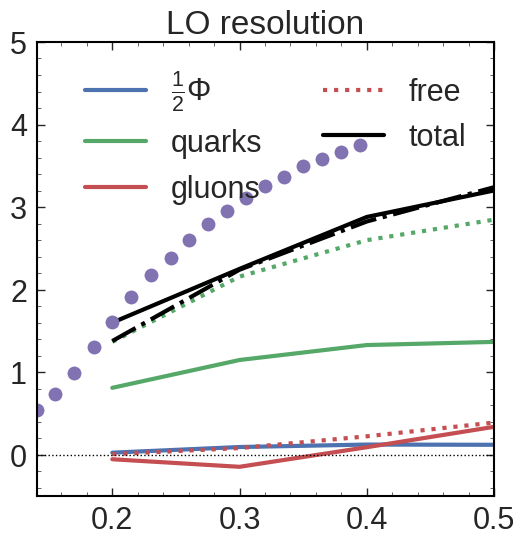

In [142]:
plt.plot(trange, (8*2*Phis_G + 3*3*2*Phis_Q)/trange**4 / 2, label=r'$\frac{1}{ 2 }\Phi$')
# plt.plot(trange, 8*2*Phis_G/trange**4 / 2)
lQ, = plt.plot(trange, 3*3*2*(ps_Q - ps_S_Q)/trange**4, label='quarks')
plt.plot(trange, 3*3*2*2*Pfree_Q/trange**4, ls=':', c=lQ.get_c())
lG, = plt.plot(trange, 8*2*(ps_G - ps_S_G)/trange**4, label='gluons')
plt.plot(trange, 8*2*Pfree_G/trange**4, ls=':', c=lG.get_c(), label='free')

plt.plot(trange, 3*3*2*2*Pfree_Q/trange**4 + 8*2*Pfree_G/trange**4, ls='-.', c='black')
plt.plot(trange, (3*3*2*(2*ps_Q - 2*ps_S_Q + Phis_Q/2) + 8*2*(ps_G - ps_S_G + Phis_G/2))/trange**4, c='black', label='total')
# plt.plot(trange, )

plt.title(mode + ' resolution')
plt.ylim(-0.5, 5)
plt.legend(ncol=2)

plt.plot(lat.x, lat.PT_lat, ls='none', marker='o')

plt.axhline(0, lw=1, ls=':', c='black')

plt.savefig(folder + 'PT_swave_'+mode+'.pdf', bbox_inches='tight')

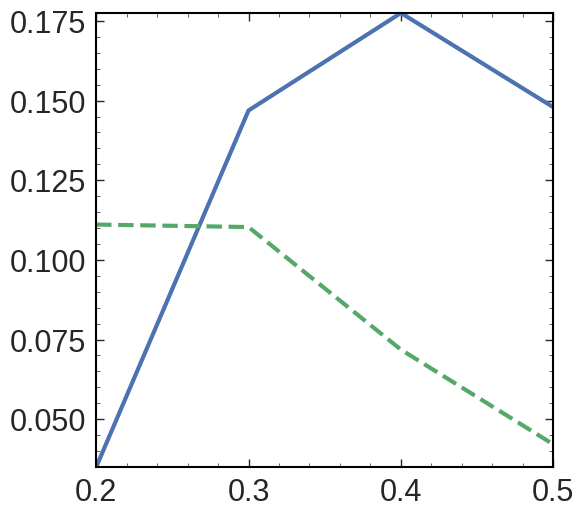

In [77]:
plt.plot(trange, (8*2*Phis_G + 3*3*2*Phis_Q*0)/trange**4 / 2)
plt.plot(trange, (8*2*Phis_G*0 + 3*3*2*Phis_Q)/trange**4 / 2, ls='--')


In [109]:
plt.plot(erange, imag(LSs[0][:, 0]))

NameError: name 'LSs' is not defined

(0.0, 2.0)

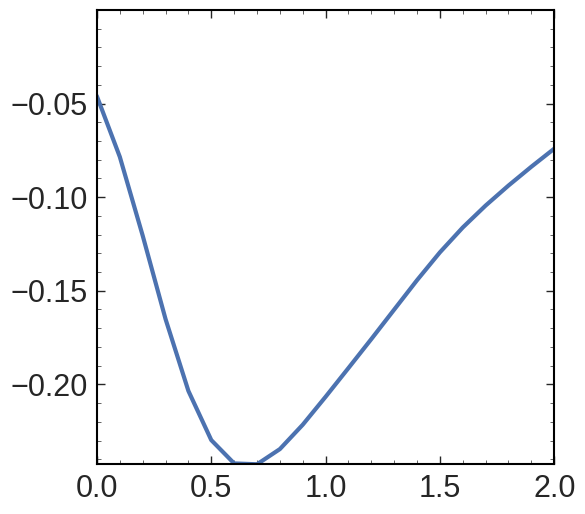

In [113]:
plt.plot(erange, imag(SQs[0][:, 0]))
plt.xlim(0, 2)

(0.0, 2.0)

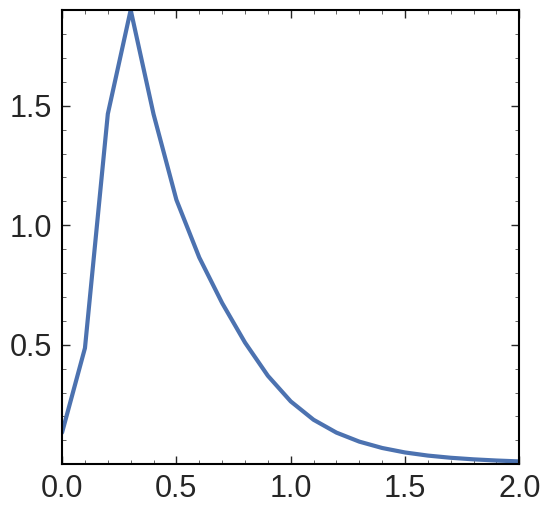

In [115]:
plt.plot(erange, pQs[0].Rtab[:, 0])

plt.xlim(0, 2)